In [180]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random

%matplotlib inline

### Data Import

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    data = np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float32)
    
    data[data > 100] = 0
    
    return data

In [13]:
def get_time_step(root, index):
    
    dep = txt_to_matrix(root + 'decoded-' + index + '.DEP')
    vvx = txt_to_matrix(root + 'decoded-' + index + '.VVX')
    vvy = txt_to_matrix(root + 'decoded-' + index + '.VVY')

    return np.array([dep, vvx, vvy])

def get_dep_time_step(root, index):
    
    dep = txt_to_matrix(root + 'decoded-' + index + '.DEP-cutted')

    return np.array([dep])

In [14]:
rootdir = '../decoded/'
prefix = 'toce_ris_V17_50-'
timesteps = []
ignore = [".DS_Store", ".", ".."]

x = 0
offset = 41
ceiling = 239

# Read all dirs and process them
for path in tqdm.tqdm(range(ceiling - offset)):
    
    # Processing
    file = rootdir + prefix
    timesteps.append(
        get_dep_time_step(
            file, ("{:04d}".format(x + offset))
        )
    )
    x += 1
        
timesteps = np.asarray(timesteps).astype(np.float32)




  0%|          | 0/198 [00:00<?, ?it/s]


  1%|          | 1/198 [00:00<00:22,  8.87it/s]


  1%|          | 2/198 [00:00<00:38,  5.13it/s]


  2%|▏         | 4/198 [00:00<00:31,  6.16it/s]


  3%|▎         | 5/198 [00:00<00:29,  6.64it/s]


  4%|▎         | 7/198 [00:01<00:26,  7.31it/s]


  5%|▍         | 9/198 [00:01<00:23,  8.09it/s]


  6%|▌         | 11/198 [00:01<00:22,  8.41it/s]


  6%|▌         | 12/198 [00:01<00:22,  8.26it/s]


  7%|▋         | 14/198 [00:01<00:21,  8.46it/s]


  8%|▊         | 16/198 [00:01<00:19,  9.15it/s]


  9%|▊         | 17/198 [00:02<00:20,  8.77it/s]


  9%|▉         | 18/198 [00:02<00:20,  8.89it/s]


 10%|▉         | 19/198 [00:02<00:20,  8.59it/s]


 10%|█         | 20/198 [00:02<00:21,  8.16it/s]


 11%|█         | 22/198 [00:02<00:19,  8.87it/s]


 12%|█▏        | 24/198 [00:02<00:18,  9.55it/s]


 13%|█▎        | 26/198 [00:02<00:17,  9.58it/s]


 14%|█▍        | 28/198 [00:03<00:17,  9.78it/s]


 15%|█▍        | 29/198 [00:03<00:19,  8.76

 84%|████████▍ | 167/198 [00:19<00:04,  7.55it/s]


 85%|████████▍ | 168/198 [00:19<00:03,  7.57it/s]


 86%|████████▌ | 170/198 [00:19<00:03,  8.05it/s]


 86%|████████▋ | 171/198 [00:20<00:03,  8.31it/s]


 87%|████████▋ | 172/198 [00:20<00:03,  8.26it/s]


 87%|████████▋ | 173/198 [00:20<00:02,  8.49it/s]


 88%|████████▊ | 175/198 [00:20<00:02,  8.87it/s]


 89%|████████▉ | 177/198 [00:20<00:02,  9.09it/s]


 90%|█████████ | 179/198 [00:20<00:02,  9.07it/s]


 91%|█████████ | 180/198 [00:21<00:02,  8.68it/s]


 91%|█████████▏| 181/198 [00:21<00:01,  8.75it/s]


 92%|█████████▏| 183/198 [00:21<00:01,  8.84it/s]


 93%|█████████▎| 184/198 [00:21<00:01,  8.38it/s]


 93%|█████████▎| 185/198 [00:21<00:01,  8.55it/s]


 94%|█████████▍| 186/198 [00:21<00:01,  8.68it/s]


 94%|█████████▍| 187/198 [00:21<00:01,  8.82it/s]


 95%|█████████▍| 188/198 [00:22<00:01,  8.38it/s]


 95%|█████████▌| 189/198 [00:22<00:01,  8.55it/s]


 96%|█████████▌| 190/198 [00:22<00:00,  8.55it/s]


 96%|███████

In [15]:
# Data preprocessing
# rimozione valori di default 1e38
threshold = 10

timesteps[timesteps > threshold] = 0

### Helper functions

In [ ]:
def scan_wet_areas(timesteps, threshold = 0.1):
    areas = []
    for j in  range(timesteps.shape[2]):
        for i in  range(timesteps.shape[3]):
            if np.sum(timesteps[:, 0, j, i]) > threshold:
                areas.append((j, i))
    return areas

### Analisi Univariata
TODO:
- plottare in questa sezione dei boxplot per alcuni pixel random
- plottare anche un hist per la distribuzione di 2 random pixel

In [18]:
def box_plot_timesteps(data, index, label):
    
    s1 = data[10][index].flatten()
    s2 = data[20][index].flatten()
    s3 = data[30][index].flatten()
    s4 = data[40][index].flatten()
    
    print("Media: \t\t\t{}".format(np.mean(data[:][index])))
    print("Deviazione std: \t{}".format(np.std(data[:][index])))

    fig, axs = plt.subplots(2, 2)
    fig.suptitle(label)

    axs[0, 0].boxplot(s1)
    axs[0, 0].set_title('t = 300\'')

    axs[0, 1].boxplot(s2)
    axs[0, 1].set_title('t = 600\'')

    axs[1, 0].boxplot(s3)
    axs[1, 0].set_title('t = 900\'')

    axs[1, 1].boxplot(s4)
    axs[1, 1].set_title('t = 1200\'')

    for ax in axs.flat:
        ax.label_outer()

Media: 			0.00010831504187081009
Deviazione std: 	0.0007689063204452395


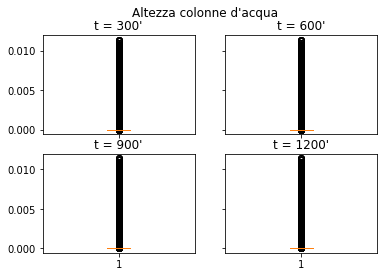

In [19]:
box_plot_timesteps(timesteps, 0, "Altezza colonne d'acqua")

In [290]:
# box_plot_timesteps(timesteps, 1, "Velocitá flussi X")

In [291]:
# box_plot_timesteps(timesteps, 2, "Velocitá flussi Y")

### Analisi Bivariata

#### Plot progressione temporale dei dati

In [21]:
def plot_map_timesteps(data, index, label):
    
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(label)

    axs[0, 0].matshow(data[10][index])
    axs[0, 0].set_title('t = 300\'')

    axs[0, 1].matshow(data[20][index])
    axs[0, 1].set_title('t = 600\'')

    axs[1, 0].matshow(data[30][index])
    axs[1, 0].set_title('t = 900\'')

    axs[1, 1].matshow(data[40][index])
    axs[1, 1].set_title('t = 1200\'')
            
    fig.subplots_adjust(hspace=0.5)
    
    for ax in axs.flat:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

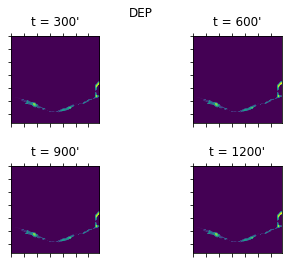

In [22]:
plot_map_timesteps(timesteps, 0, "DEP")

In [292]:
# plot_map_timesteps(timesteps, 1, "VVX")

In [293]:
# plot_map_timesteps(timesteps, 1, "VVY")

#### Correlazione tra 2 celle del fluido

In [288]:
def random_pixels_correlation(timesteps):
    
    # Pick random pixels that are not dry
    pixels = scan_wet_areas(timesteps)
    distance = int(len(pixels)/2)
    rnd = random.choice(list(range(len(pixels) - distance)))

    p1, p2 = pixels[rnd], pixels[rnd + distance]

    pixel_1 = timesteps[:, 0, p1[0], p1[1]]
    pixel_2 = timesteps[:, 0, p2[0], p2[1]]

    w = 20
    h = 20
    x_s = int(timesteps.shape[2]/2)+ 61 - w
    x_e = int(timesteps.shape[2]/2)+ 61
    y_s = int(timesteps.shape[3] - 1) - h
    y_e = int(timesteps.shape[3] - 1)

    # Plot 1
    plt.title("Punti random per confronto (t = 0)")
    plt.imshow(timesteps[0, 0], interpolation='nearest')
    plt.scatter(list(p1), list(p2), color='red', s=40)    
    
    plt.show()

    # Stats
    print("Analisi punti a scelta randomica: \nA({}, {})\nB({}, {})\n".format(p1[0], p1[1], p2[0], p2[1]))
    print("Correlazione A e B: \n{}".format(np.corrcoef(pixel_1, pixel_2)))

    # Plot 2
    plt.title("Correlazione A(x) - B(y) [altezza fluido]")
    chosen = pixel_1

    ax = plt.gca()
    ax.margins(x=-0.4, y=-0.4)

    #plt.scatter(np.arange(chosen.shape[0]), chosen)
    plt.scatter(pixel_1, pixel_2)
    plt.show()

    # Plot 3 - A
    plt.title("Andamento flusso pixel A")
    chosen = pixel_1

    ax = plt.gca()
    ax.margins(x=0.1, y=-0.40)

    plt.scatter(np.arange(chosen.shape[0]), chosen)
    plt.show()
    
    # Plot 3 - B
    plt.title("Andamento flusso pixel B")
    chosen = pixel_2

    ax = plt.gca()
    ax.margins(x=0.1, y=-0.40)

    plt.scatter(np.arange(chosen.shape[0]), chosen)
    plt.show()

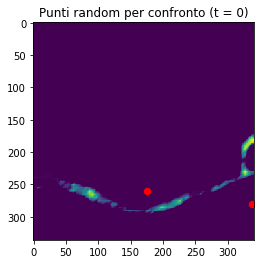

Analisi punti a scelta randomica: 
A(176, 337)
B(260, 280)

Correlazione A e B: 
[[1.         0.98973743]
 [0.98973743 1.        ]]


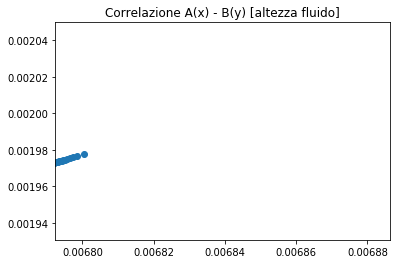

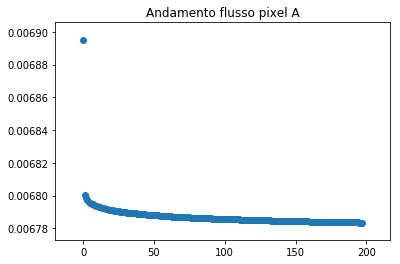

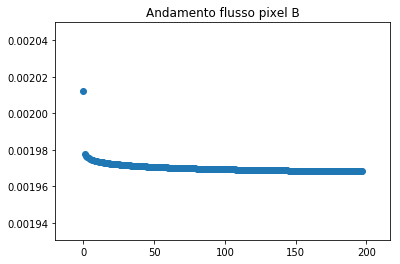

In [289]:
random_pixels_correlation(timesteps)